# 05. 수량 추정

<br>


In [1]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [3]:
from utils import set_pyplot_params
set_pyplot_params()

## 05.01. 기관차 문제

프레드릭 모스텔러의 '모스텔러의 고급 확률 문제 50선과 해답'에는 다음과 같은 기관차 문제가 수록

> "각 철도에 이 위를 지나가는 기관차에 1부터 N까지의 순서로 번호를 붙인다. 하루는 60번 번호가 붙은 기관차를 보았다. 이 떄 이 철도에는 몇 개의 기관차가 지나가는지를 추정해보자"

- 관측결과에 따르면, 이 철도에는 60개 이상의 기관차가 있다는 사실을 확인 가능 $\rightarrow$ 하지만 얼마나 더 많을까?
- 두 단계로 나누어 접근

<br>

1. 데이터를 보기 전에 $N$에 대해서 무엇을 알고 있는가?

2. 주어진 모든 $N$ 값에 대해서, 관측된 데이터 (60호 기관차)의 가능도는 어떻게 되는가?


**첫 번째 질문의 답은 사전확률 / 두 번째 질문의 답은 가능도**

<br>

사전확률분포를 선택하기전에는 근거가 부족하므로, 간단한 가정으로부터 시작
- N은 1부터 1000까지의 값 중 한 값이 동일한 확률로 선택될 수 있다고 가정

    **(전체 기차 모수 N이 1 ~ 1000대 일 확률이 동일)**

In [2]:
import numpy as np
from empiricaldist import Pmf

In [9]:
hypos = np.arange(1, 1001)
prior = Pmf(1/1000, hypos)

- 데이터의 가능도 (= N개의 기관차 가설 집단 중, 60호 기관차를 볼 확률)
    - 각 기관차를 볼 확률이 동일하다고 가정하면, 각가의 기관차를 볼 확률은 1/N)
    
    (이는 앞 장의 주사위 문제에 등장했던 갱신 함수와 동일)

In [6]:
def update_train(pmf, data):
    """새로운 데이터에 대해 pmf를 갱신"""
    hypos = pmf.qs
    likelihood = 1 / hypos
    
    # N이 60보다 작다면, 60호 기관차를 볼 확률 (= 가능도)은 0
    impossible = (data > hypos)
    likelihood[impossible] = 0
    
    pmf *= likelihood
    pmf.normalize()

- 사후분포 
    - 당연하게도 60이하의 N에 대한 모든 값은 사라짐

In [13]:
data = 60
posterior = prior.copy()
update_train(posterior, data)

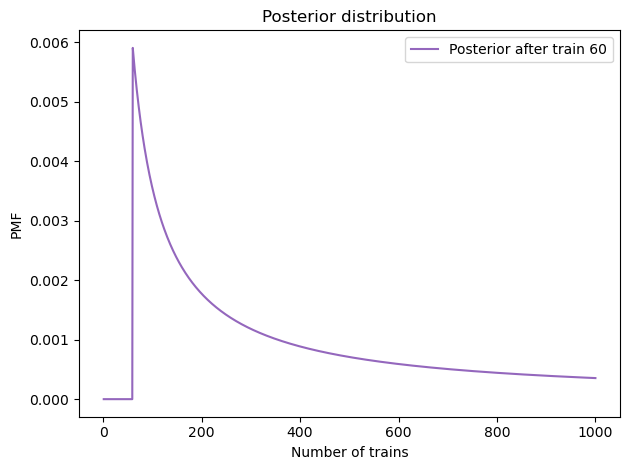

In [14]:
from utils import decorate

posterior.plot(label='Posterior after train 60', color='C4')
decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Posterior distribution')

- 가장 확률이 높은 N값은 60

In [16]:
posterior.max_prob()

60

**이는 좋은 추측이 아님.**

<br>

**이에 대한 대안으로 사후확률분포의 평균을 구함. 주어진 가능한 수 $q_i$와 이에 대한 확률 $p_i$에 대해, 분포의 평균값은**
    
$$mean = \sum_i p_i q_i$$

In [21]:
np.sum(posterior.ps * posterior.qs)

# posterior.mean()

333.4198932637079

#### 사후확률분포의 평균은 333이고, 이는 오차를 최소화하고자 할 때 좋은 선택지가 된다
#### 만약, 이런 추측 게임을 계속해서 한다면, 사후확률분포의 평균을 추정값으로 사용하는 것이 장기적으로 평균제곱오차를 줄일 수 있음

<br>

<br>

## 05.02. 사전확률에 대한 민감도

**N은 1부터 1000까지의 값 중 한 값이 동일한 확률로 선택될 수 있다고 가정하며,(전체 기차 모수 N이 1 ~ 1000대 일 확률이 동일하다는 가정) N의 상한값에 대하여 어떠한 기준을 명시하지 않았음**

<br>

#### 상한값에 대한 변화 (균등 사전확률분포의 변화)에 따라 사후확률분포가 영향을 받는지 확인
- 상한값을 다양하게 함에 따라, 사후확률분포 평균값도 달라짐 

In [24]:
import pandas as pd

In [25]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    
    update_train(pmf, data=60)
    df.loc[high] = pmf.mean()
    
df

,Posterior mean
Upper bound,
500,207.079228
1000,333.419893
2000,552.179017


#### 사후확률이 사전확률에 민감하게 반응함을 확인 $\rightarrow$ 사후확률이 사전확률에 민감하게 반응할 때는, 다음의 2가지 조치가 가능

1. **데이터를 더 확보 (관측치를 더 확보)**
2. **배경지식을 더 확보하고 더 나은 사전확률을 선택**

<br>

**데이터를 더 확보하면, 서로 다른 사전확률분포 기반으로 만들어진 사후확률분포가 수렴하는 양상을 가짐**
- 예) 60번 기관차를 본 후, 30번과 90번 기관차를 보았을 때,

    **차이는 줄어들었으나, 사후확률이 수렴하기에는 3개의 관측값으로는 충분하지 않음**

In [26]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    
    for data in dataset:
        update_train(pmf, data)
    df.loc[high] = pmf.mean()
    
df

,Posterior mean
Upper bound,
500,151.849588
1000,164.305586
2000,171.338181


<br>

## 05.03. 멱법칙 사전확률

만약 관측값을 더 확보할 수 없다면, 배경지식을 더 수집해서 사전확률을 개선하는 방식이 존재하지만, 이는 현실적으로 어려움

**따라서, 철도 경영에 특화된 정보를 얻지 않고, 학습된 추측을 할 수 있음**. 대부분의 분야에는 여러 작은 회사들이 있고, 중견급 회사들은 좀 더 적으며 대기업은 한두 개 뿐

실제로 회사규모의 분포는 로버트 엑스텔이 제안한 **멱법칙**을 따름

<br>

### 멱법칙
- 기관차가 10대 미만인 회사가 1,000개 일 때, 100대의 기관차를 소유한 회사는 100개일 것이고, 1,000대의 기관차를 소유한 회사는 10개, 10,000개대의 기관차를 소유한 회사는 1개

- **수학적으로 멱법칙은 주어진 규모 N인 회사의 수는 $(1/N)\alpha$에 비례 ($\alpha$ = 1에 가까운 크기의 매개변수)**

<br>

- 멱법칙 사전확률

In [54]:
alpha = 1.0
ps = hypos**(-alpha)
power = Pmf(ps, hypos, name='power law')
power.normalize()

8.178368103610282

- 균등분포와의 비교

In [55]:
hypos = np.arange(1, 1001)
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

1000

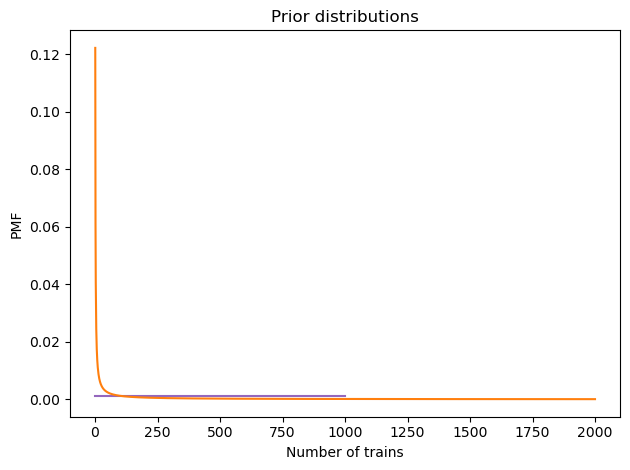

In [56]:
uniform.plot(color='C4')
power.plot(color='C1')

decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Prior distributions')

<br>

- 멱법칙 사전확률과 균등사전확률을 갱신

In [57]:
dataset = [60]
update_train(uniform, dataset)
update_train(power, dataset)

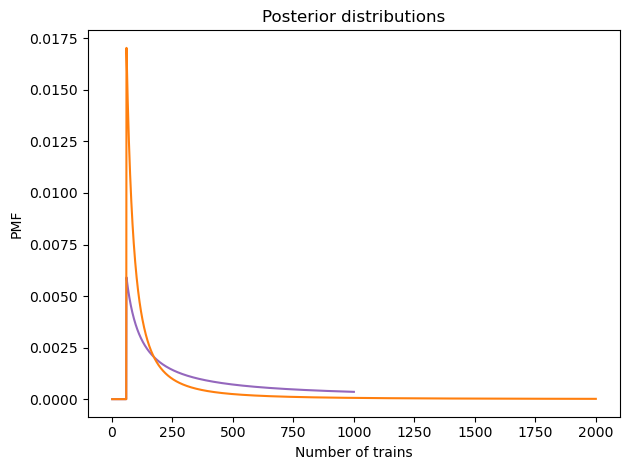

In [58]:
uniform.plot(color='C4')
power.plot(color='C1')

decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Posterior distributions')

#### 멱법칙은 큰 값에는 낮은 사전확률을 매기므로, 이에 따라 사후확률 평균이 낮아지고, 상한값에 대한 민감도도 낮아짐

<br>

#### 멱법칙 사전확률을 사용하고 세 기관차를 관측했을 때 상한선에 따른 사후확률 평균을 나타냄
- 차이가 훨씬 작은 것을 확인할 수 있으며, 상한값에 대한 평균은 134로 수렴

#### 따라서, 멱법칙은 회사의 규모에 대한 일반적인 정보를 기반으로 하므로, 보다 현실적이고 실제 상황에도 더 잘 들어맞음

In [59]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

alpha = 1.0
dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    ps = hypos**(-alpha)
    power = Pmf(ps, hypos)
    
    for data in dataset:
        update_train(power, data)
    df.loc[high] = power.mean()
    
df

,Posterior mean
Upper bound,
500,130.708470
1000,133.275231
2000,133.997463


<br>

## 05.04. 신용구간

점 추정 (point estimate)에 대한 요약하는 방법은 백분위값을 사용

$x$란 숫자가 있을 때, $x$와 같거나 더 작은 모든 숫자를 찾아내서 이에 대한 확률을 더해서 백분위 점수 (percentile rank)를 계산


<br>

- **멱법칙 사전확률과 세 개의 관측값에 대한 데이터를 사용하면**

    **x = 100일 때의 사후확률분포값 (= 기차모수 N이 100)은, 전체 사후확률분포값의 29분위 (다른 사후확률분포 값들의 29%보다 값이 높거나 같음)**

In [60]:
power.prob_le(100)

0.2937469222495771

- **빨간선 (x = 100)의 좌측 면적이 전체 분포의 29%를 차지**

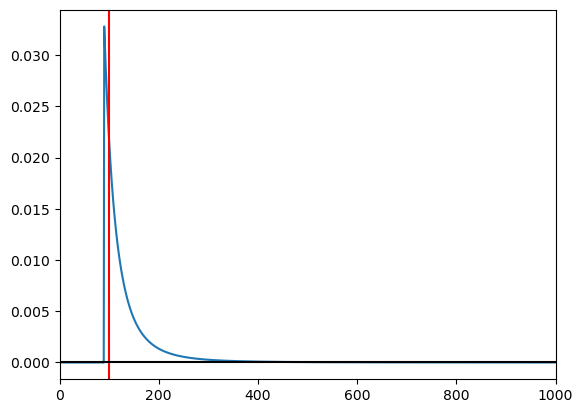

In [76]:
import matplotlib.pyplot as plt

power.plot()
plt.axvline(100, color = 'red')
plt.axhline(0, color = 'black')
plt.xlim(0, 1000)
plt.show()

<br>

**확률분포의 중간값은 50분위, 모든 확률을 더해가면서 0.5를 초과하기 시작한 때를 계산**

In [77]:
def quantile(pmf, prob):
    """주어진 확률에 대한 분위값"""
    total = 0
    
    for q, p in pmf.items():
        total += p
        if total >= prob:
            return q
        
    return np.nan

#### `items()`메소드를 사용하면, 각 x값에 대응하는 사후확률분포값을 확인 가능
- 사후분포의 50분위
- x = 113이 사후확률분포의 중간값

In [78]:
quantile(power, 0.5)

113

<br>

#### `pmf객체.quantile()` 메소드를 사용하여 5분위와 95분위 계산

In [80]:
power.quantile([0.05, 0.95])

array([ 91., 243.])

<br>

* **기관차의 수가 91 이하일 확률은 5%**
* **기관차의 수가 243보다 클 확률은 5%**

#### **따라서 [91, 243]은 90% 신용구간**

<br>

#### `pmf객체.credible_interval()`메소드를 통하여 신용구간 계산

In [81]:
power.credible_interval(0.9)

array([ 91., 243.])

<br>

## 05.05. 독일 탱크 문제

제 2차 세계대전동안, 런던의 미국대사관 전쟁경재국 (EWD)에서 독이릐 탱크 및 장비 생산량을 추정하는 데 통계 분석 기법 사용

서방 연합국에서는 각 탱크의 섀시와 엔진의 시리얼 번호를 포함한 기록 책자의 장부 및 수리기록을 확보하였다. 이를 분석하니 시리얼 번호는 제조사에 따라 할당되고, 탱크 유형을 100개의 숫자 블록으로 이루어짐

각 블록의 숫자는 순차적으로 사용되었으나, 모든 숫자를 사용하고 있는 것은 아니었다. 따라서 독일 탱크 생산량을 추정하는 문제는 100개의 숫자 블록 각각에 대해 기관차 문제 형태로 단순화 할 수 있음

이런 이해를 기반으로, 미국과 영국 분석가들은 다른 정보들을 취합한 후 추정치를 많이 낮추었음 

<hr>

<tag> 이 문제에 대해 자세한정보, [this Wikipedia page](https://en.wikipedia.org/wiki/German_tank_problem) and Ruggles and Brodie, "An Empirical Approach to Economic Intelligence in World War II", *Journal of the American Statistical Association*, March 1947, [available here](https://web.archive.org/web/20170123132042/https://www.cia.gov/library/readingroom/docs/CIA-RDP79R01001A001300010013-3.pdf).</tag>

<br>

## 05.06. 정보성 사전확률

#### 베이지안이 사전확률분포를 선택하는 방법은 두 가지

<br>

1. **문제의 배경 지식을 가장 잘 표현하는 사전확률을 선택**
- 사전확률분포는 **정보성**이며
- **정보성 사전확률분포를 사용하는 경우, 사람들이 서로 다른 배경 지식을 가지고 있거나 동일한 정보도 서로 다르게 해석한다는 문제점 존재**

<br>

2. **비정보성 사전확률** : 데이터가 최대한 직접 말할 수 있도록 제약을 두지 않음
- 추정량에 대한 최소한의 사전정보를 제공하는 등의, 몇 가지 필요한 특성을 나타나는 고유의 사전확률을 정의
- 보다 객관적

<br>

#### 베이지안 분석은 항상 모델 결정을 기반으로 이루어짐
- 사전확률 선택 역시 이러한 결정 중 하나지만, 유일한 결정사항은 아니며, 심지어 가장 주관적이지도 않음
    - **비정보성 사전확률이 더 객관적이라고 해도 전체 분석은 여전히 주관적일 수 밖에 없음**
- **현실적으로, 데이터가 굉장히 많거나 별로 없거나 하는 두 가지 상황중 하나에 처해 있을 경우가 높음**
    - 데이터가 굉장히 많은 경우라면, 사전확률분포를 무엇으로 고르든지 상관없으며, 정보성/비정보성 무관히 유사한 결과를 도출
    - 데이터가 별로 없다면, 관련 배경 지식 (멱법칙 분포 등)을 사용하면 큰 차이가 존재